# Finals MVP Award

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# ================================
# LOAD DATA
# ================================
awards = pd.read_csv("../../data/initial_data/awards_players.csv")
coaches = pd.read_csv("../../data/initial_data/coaches.csv")
players_teams = pd.read_csv("../../data/initial_data/players_teams.csv")
players = pd.read_csv("../../data/initial_data/players.csv")
series_post = pd.read_csv("../../data/initial_data/series_post.csv")
teams_post = pd.read_csv("../../data/initial_data/teams_post.csv")
teams = pd.read_csv("../../data/initial_data/teams.csv")
mvp_awards = awards[awards["award"] == "WNBA Finals Most Valuable Player"].copy()

## Feature Engineering

In [3]:
# ======================================================
# IMPORTS
# ======================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ======================================================
# HELPER FUNCTIONS
# ======================================================
def calculate_player_score(df):
    """Calculate Game Score for each player."""
    base = (
        df["points"]
        + 0.4 * df["fgMade"]
        - 0.7 * df["fgAttempted"]
        - 0.4 * (df["ftAttempted"] - df["ftMade"])
        + 0.7 * df["oRebounds"]
        + 0.3 * df["dRebounds"]
        + df["steals"]
        + 0.7 * df["assists"]
        + 0.7 * df["blocks"]
        - 0.4 * df["PF"]
        - df["turnovers"]
    )
    df = df.copy()
    df.loc[:, "Game_Score_Total"] = base
    df.loc[:, "Game_Score_Per_Minute"] = base / df["minutes"].replace(0, np.nan)
    return df


def build_player_features(players_teams_df, year):
    """Aggregate per-player features for MVP prediction."""
    df_prev = players_teams_df[players_teams_df["year"] == year - 1].copy()

    # Aggregate if multiple stints exist
    df_prev_agg = df_prev.groupby("playerID").agg({
        "tmID": "first",
        "minutes": "sum",
        "points": "sum",
        "oRebounds": "sum",
        "dRebounds": "sum",
        "assists": "sum",
        "steals": "sum",
        "blocks": "sum",
        "turnovers": "sum",
        "PF": "sum",
        "fgAttempted": "sum",
        "fgMade": "sum",
        "ftAttempted": "sum",
        "ftMade": "sum"
    }).reset_index()

    df_prev_agg = calculate_player_score(df_prev_agg)

    player_features = df_prev_agg[[
        "playerID", "tmID", "minutes", "Game_Score_Total", "Game_Score_Per_Minute"
    ]]

    return player_features


def build_team_features(players_teams_df, teams_df, year):
    """Compute team weighted score from previous season player stats."""
    team_features = []
    team_ids = teams_df[teams_df["year"] == year]["tmID"].unique()

    for team in team_ids:
        df_team = players_teams_df[(players_teams_df["year"] == year - 1) & (players_teams_df["tmID"] == team)]
        if df_team.empty:
            weighted_score = 0
        else:
            df_team = calculate_player_score(df_team)
            total_weight = df_team["Game_Score_Total"].sum()
            if total_weight == 0 or np.isnan(total_weight):
                weighted_score = 0
            else:
                weighted_score = ((df_team["Game_Score_Per_Minute"] * df_team["Game_Score_Total"]).sum() / total_weight)
        team_features.append({"tmID": team, "Team_Weighted_Score": weighted_score})

    return pd.DataFrame(team_features)


def merge_player_team_features(player_features, team_features, teams_df):
    # Keep only unique teams
    team_features_unique = team_features[["tmID", "Team_Weighted_Score", "Finals_Probability", "Conference", "year"]].drop_duplicates()

    df = player_features.merge(team_features_unique, on="tmID", how="left")
    # Make sure each player appears only once
    df = df.drop_duplicates(subset=["playerID"])

    # Optional: merge conference info from teams_df for completeness
    df = df.merge(teams_df[["tmID", "year", "confID"]].drop_duplicates(), on=["tmID", "year"], how="left")
    df.rename(columns={"confID": "Conference"}, inplace=True)

    return df


# ======================================================
# CONFERENCE-BASED FINALS PROBABILITY
# ======================================================
def predict_team_finals_prob_by_conf(team_features, teams_df, year):
    """Compute Finals probability per team (unique per team)."""
    team_features = team_features.merge(teams_df[["tmID", "confID", "year"]], on="tmID", how="left")
    team_features = team_features[team_features["year"] == year]
    team_features.rename(columns={"confID": "Conference"}, inplace=True)

    finals_probs = []
    for conf in ["EA", "WE"]:
        conf_teams = team_features[team_features["Conference"] == conf].copy()
        total_score = conf_teams["Team_Weighted_Score"].sum()
        if total_score > 0:
            conf_teams["Finals_Probability"] = conf_teams["Team_Weighted_Score"] / total_score
        else:
            conf_teams["Finals_Probability"] = 0
        finals_probs.append(conf_teams)

    team_features_unique = pd.concat(finals_probs, ignore_index=True)
    # Ensure one row per team
    team_features_unique = team_features_unique.drop_duplicates(subset=["tmID", "year"])

    return team_features_unique


def predict_player_mvp_prob_by_conf(df):
    df["MVP_Score"] = df["Game_Score_Per_Minute"] * df["Finals_Probability"]
    df["MVP_Probability"] = df["MVP_Score"] / df["MVP_Score"].sum()
    return df.sort_values("MVP_Probability", ascending=False)

# ======================================================
# HISTORICAL DATASET FOR ML TRAINING
# ======================================================
def build_historical_dataset(players_teams_df, teams_df, mvp_df, start_year, end_year):
    # Filter to Finals MVP only to be robust if full awards table is passed
    mvp_only = mvp_df[mvp_df["award"] == "WNBA Finals Most Valuable Player"].copy()
    # Guard: no range to build
    if end_year < start_year + 1:
        return pd.DataFrame(columns=[
            "playerID", "tmID", "minutes", "Game_Score_Total", "Game_Score_Per_Minute",
            "Team_Weighted_Score", "Finals_Probability", "Conference", "Finals_MVP"
        ])
    all_data = []
    for year in range(start_year + 1, end_year + 1):
        player_features = build_player_features(players_teams_df, year)
        team_features = build_team_features(players_teams_df, teams_df, year)
        team_features = predict_team_finals_prob_by_conf(team_features, teams_df, year)

        df = merge_player_team_features(player_features, team_features, teams_df)
        df["Finals_MVP"] = df["playerID"].apply(
            lambda pid: 1 if ((mvp_only["year"] == year) & (mvp_only["playerID"] == pid)).any() else 0
        )
        all_data.append(df)
    # If no seasons produced rows, return an empty DataFrame (avoids concat error)
    if len(all_data) == 0:
        return pd.DataFrame(columns=[
            "playerID", "tmID", "minutes", "Game_Score_Total", "Game_Score_Per_Minute",
            "Team_Weighted_Score", "Finals_Probability", "Conference", "Finals_MVP"
        ])
    return pd.concat(all_data, ignore_index=True)

# ======================================================
# DATA PREPARATION & MODEL TRAINING
# ======================================================
def prepare_data(df):
    feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                    "Team_Weighted_Score", "Finals_Probability"]
    X = df[feature_cols].fillna(0)
    y = df["Finals_MVP"]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


def train_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=5,
        class_weight="balanced",
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return model

# ======================================================
# PRESEASON MVP PREDICTION
# ======================================================
def preseason_mvp_ml_prediction(model, players_teams_df, teams_df, year):
    player_features = build_player_features(players_teams_df, year)
    team_features = build_team_features(players_teams_df, teams_df, year)
    team_features = predict_team_finals_prob_by_conf(team_features, teams_df, year)

    df = merge_player_team_features(player_features, team_features, teams_df)
    assert df['playerID'].duplicated().sum() == 0, "Duplicate players still exist!"

    feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                    "Team_Weighted_Score", "Finals_Probability"]

    X_pred = df[feature_cols].fillna(0)
    df["MVP_Probability"] = model.predict_proba(X_pred)[:, 1]

    return df.sort_values("MVP_Probability", ascending=False)[
        ["playerID", "tmID", "Conference", "MVP_Probability"]
    ]

# ======================================================
# EXAMPLE USAGE
# ======================================================
historical_df = build_historical_dataset(players_teams, teams, awards, 2, 10)
historical_df.to_csv("mvp_historical_dataset.csv", index=False)
X_train, X_test, y_train, y_test = prepare_data(historical_df)
model = train_model(X_train, y_train, X_test, y_test)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       287
           1       0.00      0.00      0.00         2

    accuracy                           0.99       289
   macro avg       0.50      0.50      0.50       289
weighted avg       0.99      0.99      0.99       289



c:\Users\tadeu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tadeu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tadeu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Evaluation

### Feature Importance

Game_Score_Total         0.293275
minutes                  0.218685
Team_Weighted_Score      0.188864
Game_Score_Per_Minute    0.175931
Finals_Probability       0.123244
dtype: float64


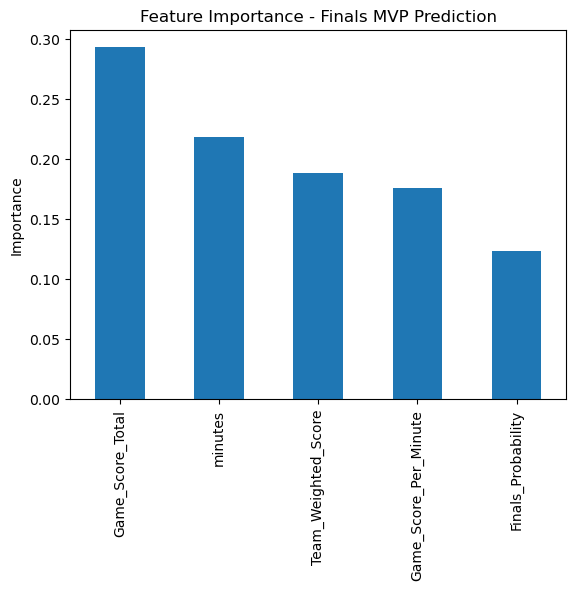

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature columns used in training
feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                "Team_Weighted_Score", "Finals_Probability"]

# Get feature importances
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

# Print importance
print(feat_importance)

# Optional: plot
feat_importance.plot(kind='bar')
plt.title("Feature Importance - Finals MVP Prediction")
plt.ylabel("Importance")
plt.show()


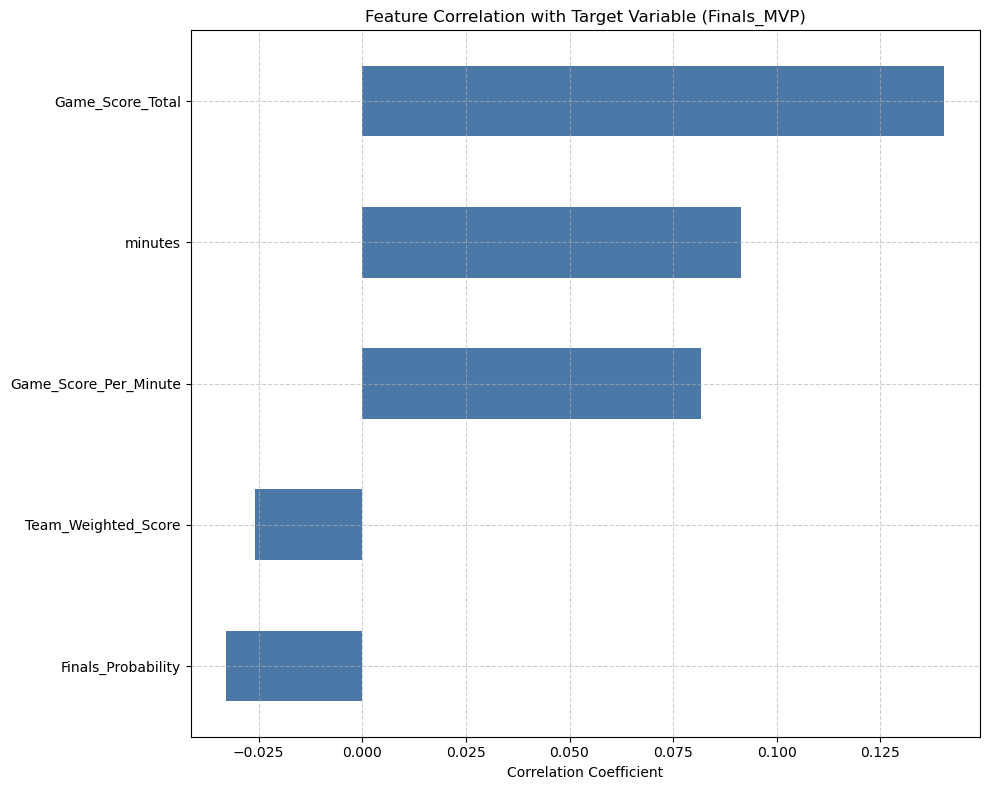

Top Positive Correlations:
Target                   1.000000
Game_Score_Total         0.140370
minutes                  0.091461
Game_Score_Per_Minute    0.081699
Team_Weighted_Score     -0.025790
Finals_Probability      -0.032765
Name: Target, dtype: float64

Top Negative Correlations:
Game_Score_Total         0.140370
minutes                  0.091461
Game_Score_Per_Minute    0.081699
Team_Weighted_Score     -0.025790
Finals_Probability      -0.032765
Name: Target, dtype: float64


In [5]:
# ===============================================
# FEATURE CORRELATION ANALYSIS (features vs Finals_MVP target)
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Build historical dataset if not already available
try:
    _ = historical_df.shape
except NameError:
    historical_df = build_historical_dataset(players_teams, teams, awards, start_year=2, end_year=10)

# Engineered features and target
feature_columns = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                   "Team_Weighted_Score", "Finals_Probability"]

# Rename target to 'Target' for clarity
candidates = historical_df[feature_columns + ["Finals_MVP"]].copy().fillna(0)
candidates = candidates.rename(columns={"Finals_MVP": "Target"})

# Compute correlation of features with Target
correlation = candidates[feature_columns + ["Target"]].corr()["Target"].sort_values(ascending=False)

# Plot correlation (horizontal bar), invert y for descending order
plt.figure(figsize=(10, 8))
correlation.drop("Target").plot(kind="barh", color="#4C78A8")
plt.title("Feature Correlation with Target Variable (Finals_MVP)")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print("Top Positive Correlations:")
print(correlation.head(6))
print("\nTop Negative Correlations:")
print(correlation.tail(5))

### Overfitting


=== RandomForest Rolling MVP Evaluation (by year) ===
   Year  Top1_Hit  Top5_Hit  Top10_Hit  Actual_MVP_Rank       AUC  Accuracy
0     3         1         1          1                1  1.000000  0.995146
1     4         0         0          0              151  0.448276  0.995098
2     5         1         1          1                1  1.000000  0.994286
3     6         1         1          1                1  1.000000  0.993865
4     7         0         0          0              109  0.469512  0.993939

=== ExtraTrees Rolling MVP Evaluation (by year) ===
   Year  Top1_Hit  Top5_Hit  Top10_Hit  Actual_MVP_Rank       AUC  Accuracy
0     3         1         1          1                1  1.000000  0.995146
1     4         0         0          0              167  0.416256  0.995098
2     5         1         1          1                1  1.000000  1.000000
3     6         1         1          1                1  1.000000  0.993865
4     7         0         0          0              133 

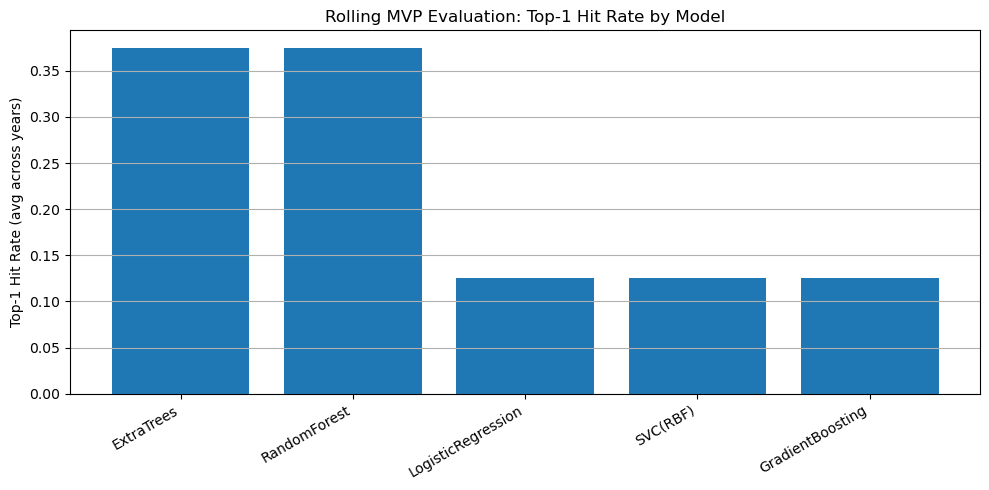

In [ ]:
# ===============================================
# ROLLING EVALUATION: multiple classifiers comparison
# Train on past seasons (< Y), predict season Y
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score

# NEW: scaling and probability calibration for linear/SVM models
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

# Candidate models (balanced for class imbalance)
candidate_models = {
    "RandomForest": RandomForestClassifier(n_estimators=500, max_depth=8, class_weight="balanced", random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=600, max_depth=None, class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    # Scale features for LR to help convergence and separability
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear", random_state=42))
    ]),
    # SVC with RBF often benefits from scaling; use calibration for better probabilities
    "SVC(RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=2.0, gamma="scale", probability=True, class_weight="balanced", random_state=42))
    ])
,}

# Shared feature columns for MVP prediction
mvp_feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                    "Team_Weighted_Score", "Finals_Probability"]

# Helper to build season Y inference set using prior-year features
def build_season_features(players_teams_df, teams_df, year):
    player_features = build_player_features(players_teams_df, year)
    team_features = build_team_features(players_teams_df, teams_df, year)
    team_features = predict_team_finals_prob_by_conf(team_features, teams_df, year)
    df = merge_player_team_features(player_features, team_features, teams_df)
    X = df[mvp_feature_cols].fillna(0)
    return df, X

# Rolling evaluation per model
# Metrics per year:
# - top1_hit: whether actual MVP is top-1 predicted
# - top3_hit: whether actual MVP is within top-3
# - actual_rank: predicted rank position of actual MVP
# - auc: ROC-AUC over all players (if probabilities available)
# - acc: accuracy with 0.5 threshold (diagnostic only)

def rolling_eval_mvp_model(model, players_teams_df, teams_df, mvp_awards_df, start_year=2, end_year=10, top_n_list=(1,3,5)):
    results = []
    # Filter to Finals MVP only
    mvp_only = mvp_awards_df[mvp_awards_df["award"] == "WNBA Finals Most Valuable Player"].copy()
    for year in range(start_year, end_year + 1):
        # Train on seasons < year
        hist_df = build_historical_dataset(players_teams_df, teams_df, mvp_only, start_year, year-1)
        # Skip if no training samples
        if hist_df.empty:
            continue
        X_train = hist_df[mvp_feature_cols].fillna(0)
        y_train = hist_df["Finals_MVP"]
        if len(X_train) == 0 or len(y_train) == 0:
            continue

        # Fit model
        model.fit(X_train, y_train)

        # Predict for target season
        df_year, X_pred = build_season_features(players_teams_df, teams_df, year)
        # Guard: model must provide probabilities
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_pred)[:, 1]
        else:
            # Fallback: decision_function scaled to [0,1] if available
            if hasattr(model, "decision_function"):
                scores = model.decision_function(X_pred)
                # Min-max scale to [0,1]
                min_s, max_s = np.min(scores), np.max(scores)
                probs = (scores - min_s) / (max_s - min_s + 1e-9)
            else:
                # As last resort, use predicted labels (poor proxy)
                preds = model.predict(X_pred)
                probs = preds.astype(float)

        df_year = df_year.copy()
        df_year["MVP_Probability"] = probs
        df_sorted = df_year.sort_values("MVP_Probability", ascending=False).reset_index(drop=True)

        # Actual MVP for year (Finals MVP only)
        actual_mvp_ids = mvp_only[mvp_only["year"] == year]["playerID"].values
        actual_mvp_id = actual_mvp_ids[0] if len(actual_mvp_ids) > 0 else None

        # Compute hits for requested top-n values
        metrics = {"Year": year}
        for k in top_n_list:
            topk = set(df_sorted.head(k)["playerID"])
            metrics[f"Top{k}_Hit"] = int(actual_mvp_id in topk) if actual_mvp_id is not None else 0

        # Actual rank position
        if actual_mvp_id is not None:
            pos = df_sorted.index[df_sorted["playerID"] == actual_mvp_id]
            actual_rank = int(pos[0] + 1) if len(pos) > 0 else None
        else:
            actual_rank = None
        metrics["Actual_MVP_Rank"] = actual_rank

        # AUC/Accuracy (diagnostic)
        try:
            # Build labels for season: 1 only for actual MVP, else 0
            y_true = (df_year["playerID"].values == actual_mvp_id).astype(int) if actual_mvp_id is not None else np.zeros(len(df_year))
            auc = roc_auc_score(y_true, probs) if len(np.unique(y_true)) > 1 else np.nan
            acc = accuracy_score(y_true, (probs >= 0.5).astype(int)) if len(np.unique(y_true)) > 1 else np.nan
        except Exception:
            auc, acc = np.nan, np.nan
        metrics["AUC"] = auc
        metrics["Accuracy"] = acc

        results.append(metrics)

    return pd.DataFrame(results)

# Run rolling evaluation for all models and build summary
comparison = {}
for name, mdl in candidate_models.items():
    df_res = rolling_eval_mvp_model(mdl, players_teams, teams, awards, start_year=2, end_year=10, top_n_list=(1,5,10))
    comparison[name] = df_res
    # Save per-model by-year metrics
    # df_res.to_csv(f"mvp_evaluation_rolling_{name}_by_year.csv", index=False)
    print(f"\n=== {name} Rolling MVP Evaluation (by year) ===")
    print(df_res.head())

# Build summary table: averages across years + rank std
summary_rows = []
for name, df in comparison.items():
    row = {"Model": name}
    for metric in ["Top1_Hit", "Top5_Hit", "Top10_Hit", "AUC", "Accuracy", "Actual_MVP_Rank"]:
        if metric in df.columns:
            # For rank lower is better; compute mean ignoring NaNs
            if metric == "Actual_MVP_Rank":
                ranks = df[metric].dropna()
                row[metric] = ranks.mean() if not ranks.empty else np.nan
                # Add standard deviation of rank
                row["Actual_MVP_Rank_STD"] = ranks.std(ddof=1) if not ranks.empty else np.nan
            else:
                row[metric] = df[metric].mean()
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
# Sort primarily by Top1_Hit desc, then Top3_Hit desc, then AUC desc, then Actual_MVP_Rank asc
summary_df = summary_df.sort_values([
    "Top1_Hit", "Top5_Hit", "Top10_Hit", "AUC", "Actual_MVP_Rank"
], ascending=[False, False, False, False, True])
summary_df.to_csv("mvp_evaluation_rolling_model_summary.csv", index=False)

print("\n=== Rolling MVP Model Comparison (higher Top1/Top3/AUC is better) ===")
print(summary_df[["Model", "Top1_Hit", "Top5_Hit", "Top10_Hit", "AUC", "Accuracy", "Actual_MVP_Rank", "Actual_MVP_Rank_STD"]])

# Plot Top1 hit rate by model
plt.figure(figsize=(10,5))
plt.bar(summary_df["Model"], summary_df["Top1_Hit"])
plt.ylabel("Top-1 Hit Rate (avg across years)")
plt.title("Rolling MVP Evaluation: Top-1 Hit Rate by Model")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


## Prediction

In [7]:
# ===============================================
# PRESEASON PREDICTION FOR SEASON 11 (using test_data)
# Trains on seasons <=10 (initial_data), predicts on year 11 teams
# Handles team ID changes strictly via test player-team map
# ===============================================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Feature columns
mvp_feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                    "Team_Weighted_Score", "Finals_Probability"]

# 1) Train a global model on seasons 2..10 using initial_data
train_df = build_historical_dataset(players_teams, teams, awards, start_year=2, end_year=10)
X_train = train_df[mvp_feature_cols].fillna(0)
y_train = train_df["Finals_MVP"]

# Recommended model from rolling results
rf_model = RandomForestClassifier(n_estimators=600, max_depth=8, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

# 2) Load test_data season 11 teams and player-team mapping, build features
players_teams_initial = players_teams  # prior season stats (year 10) available here
teams_year11_test = pd.read_csv("../../data/test_data/teams.csv")
players_teams_year11_test = pd.read_csv("../../data/test_data/players_teams.csv")

# Build season 11 features:
# - Player performance from prior season (year 10)
# - Team assignment (tmID, Conference) from test_data year 11 map to account for changes
player_features_11 = build_player_features(players_teams_initial, 11)

# Strict map: require playerID -> tmID from test_data year 11
year11_map = players_teams_year11_test[players_teams_year11_test["year"] == 11][["playerID", "tmID"]].drop_duplicates()
player_features_11 = player_features_11.merge(year11_map, on="playerID", how="left")
# Keep only players with a valid mapped tmID present in test teams
valid_tmids = set(teams_year11_test[teams_year11_test["year"] == 11]["tmID"].unique())
player_features_11 = player_features_11[player_features_11["tmID_y"].isin(valid_tmids)]
# Overwrite tmID with mapped value
player_features_11["tmID"] = player_features_11["tmID_y"]
player_features_11 = player_features_11.drop(columns=[col for col in ["tmID_y"] if col in player_features_11.columns])

# Team features use year 11 test teams (for correct conferences and any tmID changes)
team_features_11 = build_team_features(players_teams_initial, teams_year11_test, 11)
team_features_11 = predict_team_finals_prob_by_conf(team_features_11, teams_year11_test, 11)
season11_df = merge_player_team_features(player_features_11, team_features_11, teams_year11_test)

# Predict probabilities
X_11 = season11_df[mvp_feature_cols].fillna(0)
season11_df["MVP_Probability"] = rf_model.predict_proba(X_11)[:, 1]

# Standardize to a single Conference column from test teams merge
if "Conference_x" in season11_df.columns and "Conference_y" in season11_df.columns:
    season11_df["Conference"] = season11_df["Conference_y"].fillna(season11_df["Conference_x"])
    season11_df = season11_df.drop(columns=[c for c in ["Conference_x", "Conference_y"] if c in season11_df.columns])

season11_pred = season11_df.sort_values("MVP_Probability", ascending=False)[
    ["playerID", "tmID", "Conference", "MVP_Probability"]
]

print("=== Preseason Finals MVP prediction for Season 11 ===")
print(season11_pred.head(15))

# Save to CSV
season11_pred.to_csv("mvp_preseason_predictions_year11.csv", index=False)


=== Preseason Finals MVP prediction for Season 11 ===
      playerID tmID Conference Conference  MVP_Probability
62  pondeca01w  NYL         EA         EA         0.231832
13  catchta01w  IND         EA         EA         0.197386
24  hammobe01w  SAS         WE         WE         0.167508
79  tauradi01w  PHO         WE         WE         0.078237
63  powelni01w  NYL         EA         EA         0.068663
19  dupreca01w  PHO         WE         WE         0.051667
92  youngso01w  SAS         WE         WE         0.034580
25  hardili01w  ATL         EA         EA         0.030000
81  thompti01w  LAS         WE         WE         0.023333
40  lattaiv01w  TUL         WE         WE         0.015000
1   anosini01w  WAS         EA         EA         0.014973
39  langhcr01w  WAS         EA         EA         0.008239
32  jacksla01w  SEA         WE         WE         0.006667
91  wrighta01w  SEA         WE         WE         0.006667
33  jacksti02w  TUL         WE         WE         0.006667
